# QM7 Dataset

This dataset is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) composed of all molecules of up to 23 atoms (including 7 heavy atoms C, N, O, and S), totalling 7165 molecules. We provide the Coulomb matrix representation of these molecules and their atomization energies computed similarly to the FHI-AIMS implementation of the Perdew-Burke-Ernzerhof hybrid functional (PBE0). This dataset features a large variety of molecular structures such as double and triple bonds, cycles, carboxy, cyanide, amide, alcohol and epoxy. 

The Coulomb matrix is defined as:
  * $C_{i,i} = 0.5 \cdot Z^{2.4}$  
  * $C_{i,j} =   \frac{Z_i\cdot Z_j}{|(R_i−R_j)|}$ 
  * $Z_i$ - nuclear charge of atom i  
  * $R_i$ - cartesian coordinates of atom i  

The data file (.mat format) contains five arrays:  
  * "X" - (7165 x 23 x 23), Coulomb matrices  
  * "T" - (7165), atomization energies (unit: kcal/mol)  
  * "P" - (5 x 1433), cross-validation splits as used in [Montavon et al. NIPS, 2012]  
  * "Z" - (7165 x 23), atomic charges  
  * "R" - (7165 x 23 x 3), cartesian coordinate (unit: Bohr) of each atom in the molecules   


# Library

In [1]:
import pandas as pd
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch
import time
from tqdm.notebook import tqdm
import os

import warnings
warnings.simplefilter('ignore')

rand_state = 42
np.random.seed(rand_state)

# Feature Engineer
Step:
1. Take upper half of the matrix (because A[i,j]=A[j,i] => reduce compute step)
2. Calculate distance matrix (using R)
3. Calculate eigenvalue and eigenvector centralities (Katz Index) (how important one node/atoms compare to others in the molecules)

In [2]:
qm7 = scipy.io.loadmat('../data/qm7.mat')

In [3]:
# Cartesian Coordinate matrix
R=qm7['R']


# Reshape energy to (7165,) and normalize
y = np.transpose(qm7['T']).reshape((7165,))
std=(y-y.mean()).std()
y_scaled = (y -y.mean())/ std
y_scaled.shape

(7165,)

In [4]:
## Step 1: Take upper half
# (idx) to access the elements of the matrix in the upper triangle including the diagonal (k=0). 
# (idx_dist) to access the elements of the distance matrix in the upper triangle excluding the diagonal (k=1).
num_atoms = 23
idx = np.triu_indices(num_atoms,k=0) 
idx_dist = np.triu_indices(num_atoms,k=1)


In [5]:
# Initialize placeholder
coulomb_matrix = np.zeros((qm7['X'].shape[0], num_atoms*(num_atoms+1)//2), dtype=float)
eigs = np.zeros((qm7['X'].shape[0], num_atoms), dtype=float)
centralities = np.zeros((qm7['X'].shape[0], num_atoms), dtype=float)
dist_matrix = np.zeros((qm7['X'].shape[0], ((num_atoms*num_atoms)-num_atoms)//2), dtype=float)

In [6]:
for i in tqdm(range(len(qm7['X']))):
    # Extract the Coulomb vector from the Coulomb matrix (cm) and sort the elements in descending order.
    cm=qm7['X'][i]
    coulomb_vector = cm[idx]
    sorted_cv = np.argsort(-coulomb_vector)
    coulomb_matrix[i] = coulomb_vector[sorted_cv]

    ## Step 2: Compute the distance matrix (dist) from the coordinate matrix (R)
    # Extract the distance vector from the distance matrix, then sort the elements in descending order.
    dist = squareform(pdist(R[i]))
    dist_vector = dist[idx_dist]
    sorted_dv = np.argsort(-dist_vector)
    dist_matrix[i] = dist_vector[sorted_dv]

    
    # Compute the eigenvalues (w) and eigenvectors (v) of the distance matrix.
    eig_value, eig_vector = np.linalg.eig(dist)
    eigs[i] = eig_value[np.argsort(-eig_value)]

    ## Step 3: Compute the eigenvector centrality of the graph created from the distance matrix
    # Assign the centrality values to the corresponding row in the centralities matrix.
    centralities[i] = np.array(list(nx.eigenvector_centrality(nx.Graph(dist)).values()))

  0%|          | 0/7165 [00:00<?, ?it/s]

In [7]:
X = np.concatenate((coulomb_matrix, eigs, centralities, dist_matrix), axis=1)
X.shape

(7165, 575)

# Visualize

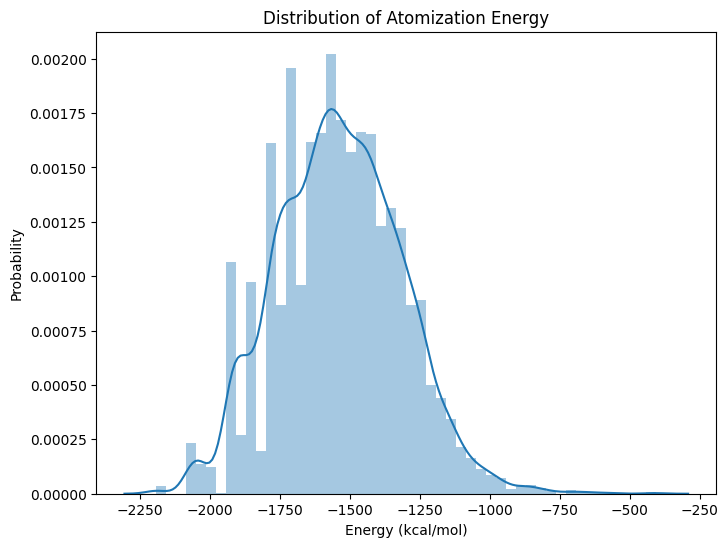

In [8]:
plt.figure(figsize=(8,6))
sns.distplot(y)
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of Atomization Energy')
plt.show()

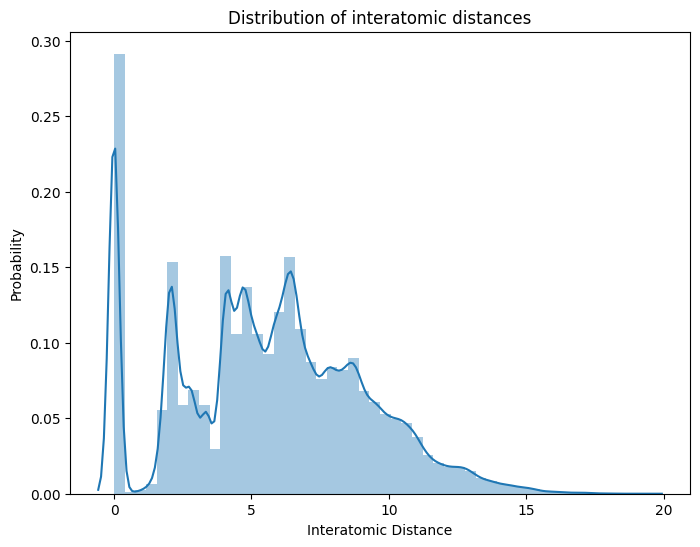

In [9]:
plt.figure(figsize=(8,6))
sns.distplot(dist_matrix)
plt.xlabel('Interatomic Distance')
plt.ylabel('Probability')
plt.title('Distribution of interatomic distances')
plt.show()

# Saving

In [11]:
path='../data'
data = {
    'X': X,
    'y': y_scaled,
    'P': qm7['P'],
    'Z': qm7['Z'],
    'R': qm7['R']
}

# Save the dictionary as a .mat file
scipy.io.savemat(os.path.join(path,'preprocessed.mat'), data)